[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1qvWtS85_jo_50b5GJQ5G51rliMw7_yV8?usp=sharing)

# Lab 2: Adding Memory

This notebook builds on Lab 1 by adding tools and persistent memory to our cake shop assistant,
making it more powerful and useful for business applications.

In [1]:
!pip install -q langgraph langchain_openai langchain_community langgraph_supervisor langgraph-checkpoint-sqlite langchain_experimental \
   pymupdf chromadb grandalf gradio pandas

In [2]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [3]:
from typing import Annotated, List, Dict, Any, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
import pandas as pd
import requests
import os
import sqlite3
from langchain_openai import ChatOpenAI
from langchain.agents import Tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_community.document_loaders import CSVLoader, TextLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnablePassthrough

In [4]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("TT_OPENAI_KEY")

In [5]:
model_name = "gpt-4o-mini"
llm = ChatOpenAI(model=model_name, temperature=0)

In [6]:
os.makedirs('./data', exist_ok=True)
os.makedirs('./report', exist_ok=True)

In [7]:
import requests

os.makedirs('./data', exist_ok=True)

links = [
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/accessories.pdf', "name": "accessories"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/cupcakes.pdf', "name": "cupcakes"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/desserts.pdf', "name": "desserts"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/cakes.pdf', "name": "cakes"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/cake_descriptions.csv', "name": "cake_table"}
]

for link in links:

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
    }

    response = requests.get(
        link["url"],
        headers=headers,
    )

    if link['name'] == "cake_table":
      _path = f"./data/{link['name']}.csv"
    else:
      _path = f"./data/{link['name']}.pdf"
    with open(_path, "wb") as f:
      f.write(response.content)

In [8]:
pdf_documents = []
for pdf_link in os.listdir("./data"):
    if pdf_link[-3:] == "pdf":
      pdf_loader = PyMuPDFLoader(f"./data/{pdf_link}")
      data = pdf_loader.load()
      pdf_documents += data

In [9]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50, #this is a great parameter to experiment
    separators=["\n\n", "\n", ".", ","] #what other separators can you think off?
)

# Split the documents
chunks = text_splitter.split_documents(pdf_documents)
print(f"Created {len(chunks)} chunks from {len(pdf_documents)} documents")
print(f"Sample chunk: {chunks[0].page_content[:50]}...")

Created 52 chunks from 11 documents
Sample chunk: Cakes descriptions 
==============================...


In [10]:
# Initialize embeddings
embeddings = OpenAIEmbeddings(model = "text-embedding-3-large")

# Create a Chroma vector store
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 10, })

In [11]:
# Load cake data
cake_data = pd.read_csv("./data/cake_table.csv", encoding='cp1252')

In [12]:
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.tools import BaseTool, tool, StructuredTool, Tool
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.agents import create_pandas_dataframe_agent
from pydantic import BaseModel, Field
import pandas as pd

In [13]:
# Define RAG search tool
@tool
def search_cake_descriptions(query: str) -> str:
    """Search for information about cakes, desserts and accessories descriptions"""
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

# Define CSV query tool
class CSVQueryInput(BaseModel):
    """Input for CSV query tool."""
    query: str = Field(description="The query or question about the CSV data")

class CSVAgentTool(BaseTool):
    """Tool for analyzing CSV data"""
    name: str = "csv_data_analyzer"
    description: str = """Analyze CSV data by asking questions in natural language. This tool can access information about:
        ingredients, short description, energy_kcal, weight_grams, restrictions, delivery_time_hr, availability"""
    args_schema: type[BaseModel] = CSVQueryInput
    return_direct: bool = True

    def _run(self, query: str) -> str:
        """Run the tool."""
        try:
            # Load the CSV into a pandas DataFrame
            df = pd.read_csv("./data/cake_table.csv", encoding='cp1252')

            # Create a Pandas DataFrame agent
            agent = create_pandas_dataframe_agent(
                ChatOpenAI(temperature=0, model=model_name),
                df,
                verbose=True,
                agent_type="openai-functions",
                allow_dangerous_code=True
            )

            # Run the agent on the query
            result = agent.run(query)
            return result

        except Exception as e:
            return f"Error processing CSV query: {str(e)}"

    async def _arun(self, query: str) -> str:
        """Run the tool asynchronously."""
        return self._run(query)

# Instantiate the CSV tool
csv_tool = CSVAgentTool()

In [14]:
# Create a Python REPL tool
python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Execute Python code to analyze data. Input should be valid Python code.",
    func=python_repl.run
)

### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [15]:
tools = [search_cake_descriptions, csv_tool, repl_tool]

In [16]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [17]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [18]:
# This is different:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [19]:
# Step 3: Create a Node


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [20]:
# Step 4: Create Edges


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

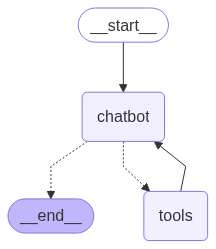

In [21]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content

In [23]:
TEST_MODE = False
if TEST_MODE:
  gr.ChatInterface(chat, type="messages").launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0530379be3fd5a867c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [24]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [25]:
# Steps 1 and 2
graph_builder = StateGraph(State)

# Step 3
llm = ChatOpenAI(model=model_name)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

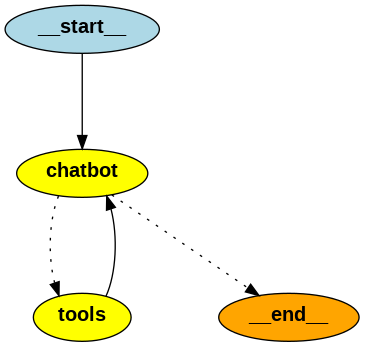

In [26]:
# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_png()))

In [27]:
query = "Name 5 cakes with nuts"
config = {"configurable": {"thread_id": 1}, "recursion_limit": 10}

for s in graph.stream(
    {"messages": [{"role": "user", "content": query}]}, config=config
):
    print(s)
    print("---")

{'messages': [HumanMessage(content='Name 5 cakes with nuts', additional_kwargs={}, response_metadata={}, id='6cbc511c-eb59-4014-9ece-418c95f55770')]}
{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kCmeg11wwhpLey9o2jRy1ss4', 'function': {'arguments': '{"query":"cakes with nuts"}', 'name': 'search_cake_descriptions'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 157, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXOt8ElYSGcwbkcQod0s19JfwjBoO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--50f20486-220d-401b-947e-6918fbc45f2b-0', tool_calls=[{'name': 'search_ca

In [28]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Name 5 cakes with nuts', additional_kwargs={}, response_metadata={}, id='6cbc511c-eb59-4014-9ece-418c95f55770'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kCmeg11wwhpLey9o2jRy1ss4', 'function': {'arguments': '{"query":"cakes with nuts"}', 'name': 'search_cake_descriptions'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 157, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXOt8ElYSGcwbkcQod0s19JfwjBoO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--50f20486-220d-401b-947e-6918fbc45f2b-0', tool_calls=[{'name': 'search_cake_des

In [29]:
query = "Do they contain berries?"
config = {"configurable": {"thread_id": 1}, "recursion_limit": 10}

for s in graph.stream(
    {"messages": [{"role": "user", "content": query}]}, config=config
):
    print(s)
    print("---")

{'messages': [HumanMessage(content='Name 5 cakes with nuts', additional_kwargs={}, response_metadata={}, id='6cbc511c-eb59-4014-9ece-418c95f55770'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kCmeg11wwhpLey9o2jRy1ss4', 'function': {'arguments': '{"query":"cakes with nuts"}', 'name': 'search_cake_descriptions'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 157, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXOt8ElYSGcwbkcQod0s19JfwjBoO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--50f20486-220d-401b-947e-6918fbc45f2b-0', tool_calls=[{'name': 'search_cake_descriptions', 'args': {

<ipython-input-13-98136846df0c>:37: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = agent.run(query)




> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df[df['Name'].str.contains('Carrot Cake', case=False)]['Ingredients']"}`


14    Carrots, walnuts, spices, cream cheese
Name: Ingredients, dtype: object
Invoking: `python_repl_ast` with `{'query': "df[df['Name'] == 'Hazelnut Toffee Crown']['Ingredients'].values[0]"}`


Hazelnuts, caramel, praline, brown sugar sponge
Invoking: `python_repl_ast` with `{'query': "df.loc[df['Name'] == 'Dubai Midnight Pistachio Fantasy', 'Ingredients'].values[0]"}`


Pistachios, rose syrup, cardamom, white chocolate, datesThe ingredients for Carrot Cake include carrots, walnuts, spices, and cream cheese. It does not contain berries.

> Finished chain.

Invoking: `python_repl_ast` with `{'query': "sacher_torte = df[df['Name'] == 'Sacher Torte']\nsacher_torte"}`
respo

In [30]:
query = "What about chocolate?"
config = {"configurable": {"thread_id": 2}, "recursion_limit": 10}

for s in graph.stream(
    {"messages": [{"role": "user", "content": query}]}, config=config
):
    print(s)
    print("---")

{'messages': [HumanMessage(content='What about chocolate?', additional_kwargs={}, response_metadata={}, id='ced5ed13-f046-45f2-a68c-35fb5ea38027')]}
{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3JgDLIYQSXTDJhN7O4D484L7', 'function': {'arguments': '{"query":"chocolate"}', 'name': 'search_cake_descriptions'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 155, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXOtTjra6LVtYRKgHHGcKt4DvUMu9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1ecfc30d-6fb4-41bc-b0d2-5bc339292abe-0', tool_calls=[{'name': 'search_cake_desc

In [31]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='What about chocolate?', additional_kwargs={}, response_metadata={}, id='ced5ed13-f046-45f2-a68c-35fb5ea38027'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3JgDLIYQSXTDJhN7O4D484L7', 'function': {'arguments': '{"query":"chocolate"}', 'name': 'search_cake_descriptions'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 155, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXOtTjra6LVtYRKgHHGcKt4DvUMu9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1ecfc30d-6fb4-41bc-b0d2-5bc339292abe-0', tool_calls=[{'name': 'search_cake_descriptio

## Step 5: Set up SQL Database for Memory

We'll use SQLite to store conversation history, allowing our assistant
to remember previous interactions with customers.

In [32]:
# Set up SQLite database for memory
db_path = "cake_shop_memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

In [33]:
graph = graph_builder.compile(checkpointer=sql_memory)

In [34]:
query = "Name 5 cakes with nuts"
config = {"configurable": {"thread_id": 1}, "recursion_limit": 10}

for s in graph.stream(
    {"messages": [{"role": "user", "content": query}]}, config=config
):
    print(s)
    print("---")

{'messages': [HumanMessage(content='Name 5 cakes with nuts', additional_kwargs={}, response_metadata={}, id='7717adef-6abe-4217-96d2-a57b4c3dad87'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xrkpwEtqXgMKOFy6MEPGgnBQ', 'function': {'arguments': '{"query":"cakes with nuts"}', 'name': 'search_cake_descriptions'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 157, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXOeyBqBog6EJon0IUa2HgjAVWG9x', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a25532d4-0d5e-47af-8d7b-89a470f3860a-0', tool_calls=[{'name': 'search_cake_descriptions', 'args': {

In [35]:
query = "Do they contain berries?"
config = {"configurable": {"thread_id": 1}, "recursion_limit": 10}

for s in graph.stream(
    {"messages": [{"role": "user", "content": query}]}, config=config
):
    print(s)
    print("---")

{'messages': [HumanMessage(content='Name 5 cakes with nuts', additional_kwargs={}, response_metadata={}, id='7717adef-6abe-4217-96d2-a57b4c3dad87'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xrkpwEtqXgMKOFy6MEPGgnBQ', 'function': {'arguments': '{"query":"cakes with nuts"}', 'name': 'search_cake_descriptions'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 157, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXOeyBqBog6EJon0IUa2HgjAVWG9x', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a25532d4-0d5e-47af-8d7b-89a470f3860a-0', tool_calls=[{'name': 'search_cake_descriptions', 'args': {

In [36]:
query = "What about chocolate?"
config = {"configurable": {"thread_id": 2}, "recursion_limit": 10}

for s in graph.stream(
    {"messages": [{"role": "user", "content": query}]}, config=config
):
    print(s)
    print("---")

{'messages': [HumanMessage(content='What about chocolate?', additional_kwargs={}, response_metadata={}, id='940cc887-a669-4e12-acde-e24a426f997f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ETg9fGd4SBMIgpKoMnJ5q0xJ', 'function': {'arguments': '{"query":"chocolate"}', 'name': 'search_cake_descriptions'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 155, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXOfG9M1CMaDPhmQmnt20xoUKfyqG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--235aa934-573c-4c73-976c-5589cb3850cc-0', tool_calls=[{'name': 'search_cake_descriptions', 'args': {'query'

In [37]:
import sqlite3
con = sqlite3.connect("cake_shop_memory.db")
cur = con.cursor()

In [38]:
import sqlite3

def get_all_tables(db_file):
    """
    Retrieves a list of all table names in a SQLite database.

    Args:
        db_file (str): The path to the SQLite database file.

    Returns:
        list: A list of strings, where each string is the name of a table.
              Returns an empty list if there's an error or no tables are found.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        cursor = conn.cursor()

        # Query sqlite_master to get all tables
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()

        # Extract table names from the result
        table_names = [table[0] for table in tables]
        return table_names

    except sqlite3.Error as e:
        print(f"Error accessing database: {e}")
        return []
    finally:
        if conn:
            conn.close()

# Example usage:
database_file = 'cake_shop_memory.db'  # Replace with the actual path to your database file
all_tables = get_all_tables(database_file)

if all_tables:
    print("Tables in the database:")
    for table in all_tables:
        print(f"- {table}")
else:
    print("No tables found in the database.")

Tables in the database:
- checkpoints
- writes


In [39]:
import sqlite3
import pandas as pd

def present_query_in_table(db_file, query):
    """
    Executes a SQL query on a SQLite database and presents the results as a pandas DataFrame.

    Args:
        db_file (str): The path to the SQLite database file.
        query (str): The SQL query to execute.

    Returns:
        pandas.DataFrame: A DataFrame containing the query results, or None if an error occurs.
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(query, conn)
        return df
    except sqlite3.Error as e:
        print(f"Error executing query: {e}")
        return None
    finally:
        if conn:
            conn.close()

database_file = 'cake_shop_memory.db'  # Replace with the actual path to your database file
query = "SELECT * FROM writes;"

results_df = present_query_in_table(database_file, query)

In [40]:
results_df

,thread_id,checkpoint_ns,checkpoint_id,task_id,idx,channel,type,value
0,1,,1f0316a5-25dd-6fc8-bfff-bcf30953660f,34655cb5-032d-8922-8e38-8fa1c34ac4c9,0,messages,msgpack,b'\x91\x82\xa4role\xa4user\xa7content\xb6Name ...
1,1,,1f0316a5-25dd-6fc8-bfff-bcf30953660f,34655cb5-032d-8922-8e38-8fa1c34ac4c9,1,branch:to:chatbot,null,b''
2,1,,1f0316a5-25e1-6d07-8000-cbaa7267a08b,2c4652e2-f77f-023d-c17f-cd01c8177baa,0,messages,msgpack,b'\x91\xc8\x03\xe8\x05\x94\xbalangchain_core.m...
3,1,,1f0316a5-25e1-6d07-8000-cbaa7267a08b,2c4652e2-f77f-023d-c17f-cd01c8177baa,1,branch:to:tools,null,b''
4,1,,1f0316a5-2e39-6a87-8001-94522980090c,db233e39-c246-9b95-4e04-bb70897f9a75,0,messages,msgpack,"b""\x91\xc8\x13\x1b\x05\x94\xbclangchain_core.m..."
5,1,,1f0316a5-2e39-6a87-8001-94522980090c,db233e39-c246-9b95-4e04-bb70897f9a75,1,branch:to:chatbot,null,b''
6,1,,1f0316a5-332c-631e-8002-7496455fc954,3910c087-6884-d6d0-8622-f4fb4e1b2a88,0,messages,msgpack,"b""\x91\xc8\x07)\x05\x94\xbalangchain_core.mess..."
7,1,,1f0316a5-6133-63ea-8004-d5230f3be4f7,22ea6b9d-36b2-df17-8b76-520b9e257e7c,0,messages,msgpack,b'\x91\x82\xa4role\xa4user\xa7content\xb8Do th...
8,1,,1f0316a5-6133-63ea-8004-d5230f3be4f7,22ea6b9d-36b2-df17-8b76-520b9e257e7c,1,branch:to:chatbot,null,b''
9,1,,1f0316a5-6137-6e97-8005-330946861fb6,ddddab1a-0294-6cf2-5fe3-7fed1a043514,0,messages,msgpack,b'\x91\xc8\x08Q\x05\x94\xbalangchain_core.mess...


In [41]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='What about chocolate?', additional_kwargs={}, response_metadata={}, id='940cc887-a669-4e12-acde-e24a426f997f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ETg9fGd4SBMIgpKoMnJ5q0xJ', 'function': {'arguments': '{"query":"chocolate"}', 'name': 'search_cake_descriptions'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 155, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BXOfG9M1CMaDPhmQmnt20xoUKfyqG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--235aa934-573c-4c73-976c-5589cb3850cc-0', tool_calls=[{'name': 'search_cake_descriptio

In [42]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8fe5b66969bdadb67b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [43]:
results_df = present_query_in_table(database_file, query)

In [44]:
results_df

,thread_id,checkpoint_ns,checkpoint_id,task_id,idx,channel,type,value
0,1,,1f0316a5-25dd-6fc8-bfff-bcf30953660f,34655cb5-032d-8922-8e38-8fa1c34ac4c9,0,messages,msgpack,b'\x91\x82\xa4role\xa4user\xa7content\xb6Name ...
1,1,,1f0316a5-25dd-6fc8-bfff-bcf30953660f,34655cb5-032d-8922-8e38-8fa1c34ac4c9,1,branch:to:chatbot,null,b''
2,1,,1f0316a5-25e1-6d07-8000-cbaa7267a08b,2c4652e2-f77f-023d-c17f-cd01c8177baa,0,messages,msgpack,b'\x91\xc8\x03\xe8\x05\x94\xbalangchain_core.m...
3,1,,1f0316a5-25e1-6d07-8000-cbaa7267a08b,2c4652e2-f77f-023d-c17f-cd01c8177baa,1,branch:to:tools,null,b''
4,1,,1f0316a5-2e39-6a87-8001-94522980090c,db233e39-c246-9b95-4e04-bb70897f9a75,0,messages,msgpack,"b""\x91\xc8\x13\x1b\x05\x94\xbclangchain_core.m..."
5,1,,1f0316a5-2e39-6a87-8001-94522980090c,db233e39-c246-9b95-4e04-bb70897f9a75,1,branch:to:chatbot,null,b''
6,1,,1f0316a5-332c-631e-8002-7496455fc954,3910c087-6884-d6d0-8622-f4fb4e1b2a88,0,messages,msgpack,"b""\x91\xc8\x07)\x05\x94\xbalangchain_core.mess..."
7,1,,1f0316a5-6133-63ea-8004-d5230f3be4f7,22ea6b9d-36b2-df17-8b76-520b9e257e7c,0,messages,msgpack,b'\x91\x82\xa4role\xa4user\xa7content\xb8Do th...
8,1,,1f0316a5-6133-63ea-8004-d5230f3be4f7,22ea6b9d-36b2-df17-8b76-520b9e257e7c,1,branch:to:chatbot,null,b''
9,1,,1f0316a5-6137-6e97-8005-330946861fb6,ddddab1a-0294-6cf2-5fe3-7fed1a043514,0,messages,msgpack,b'\x91\xc8\x08Q\x05\x94\xbalangchain_core.mess...
